#### Libraries

In [1]:
#local libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#spark

import databricks.koalas as ks
from pyspark import SparkConf
from pyspark.sql import SparkSession

#### Spark conf and SparkSession

In [2]:
conf = SparkConf().setAll([("spark.master", "local"), ("spark.driver.memory", "2G")])

spark = SparkSession.builder.config(conf = conf).getOrCreate()

In [3]:
spark

### Import data

In [4]:
df = ks.read_csv("/Users/ramonsotogarcia/Desktop/Data/diamonds.csv", header = 0)

df.spark.cache()

df.count()

carat            53940
depth            53940
table            53940
price            53940
x                53940
y                53940
z                53940
cut.Fair         53940
cut.Good         53940
cut.Very.Good    53940
cut.Premium      53940
cut.Ideal        53940
color.D          53940
color.E          53940
color.F          53940
color.G          53940
color.H          53940
color.I          53940
color.J          53940
clarity.I1       53940
clarity.SI2      53940
clarity.SI1      53940
clarity.VS2      53940
clarity.VS1      53940
clarity.VVS2     53940
clarity.VVS1     53940
clarity.IF       53940
dtype: int64

### Missing values

In [5]:
df.isna().sum(axis=0)/ df.shape[0]

carat            0.0
depth            0.0
table            0.0
price            0.0
x                0.0
y                0.0
z                0.0
cut.Fair         0.0
cut.Good         0.0
cut.Very.Good    0.0
cut.Premium      0.0
cut.Ideal        0.0
color.D          0.0
color.E          0.0
color.F          0.0
color.G          0.0
color.H          0.0
color.I          0.0
color.J          0.0
clarity.I1       0.0
clarity.SI2      0.0
clarity.SI1      0.0
clarity.VS2      0.0
clarity.VS1      0.0
clarity.VVS2     0.0
clarity.VVS1     0.0
clarity.IF       0.0
dtype: float64

Parece que el dataframe no tiene NAs

In [6]:
df.head(5)

,carat,depth,table,price,x,y,z,cut.Fair,cut.Good,cut.Very.Good,cut.Premium,cut.Ideal,color.D,color.E,color.F,color.G,color.H,color.I,color.J,clarity.I1,clarity.SI2,clarity.SI1,clarity.VS2,clarity.VS1,clarity.VVS2,clarity.VVS1,clarity.IF
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


### Feature engineering

In [7]:
#variable diamond type

df["DiamondType"] = "Fair"
df.loc[df["cut.Ideal"] == 1, ["DiamondType"]] = "Ideal"
df.loc[df["cut.Good"] == 1, ["DiamondType"]] = "Good"
df.loc[df["cut.Very.Good"] == 1, ["DiamondType"]] = "Very good"
df.loc[df["cut.Premium"] == 1, ["DiamondType"]] = "Premium"

#seleccionamos las variables que nos interesa

df = df.loc[:, ["carat", "price", "table", "x", "y", "z", "DiamondType"]]



In [8]:
df.groupby("DiamondType").count().sort_values(by = "carat", ascending = False)["carat"]

DiamondType
Ideal        21551
Premium      13791
Very good    12082
Good          4906
Fair          1610
Name: carat, dtype: int64

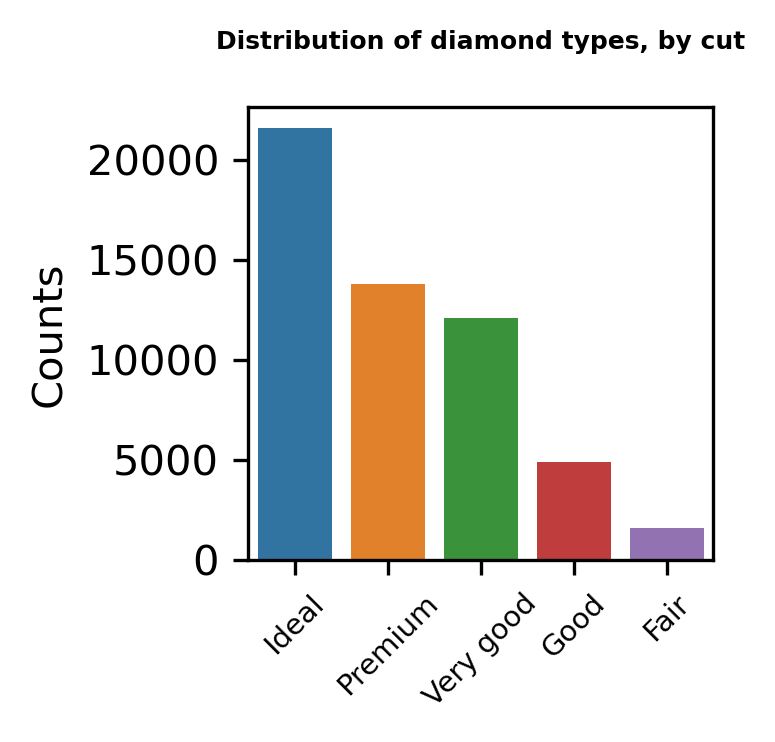

In [9]:
new = df.groupby("DiamondType").count().sort_values(by = "carat", ascending = False)

diamond_type = new.index.to_numpy()
counts = df.groupby("DiamondType").count().sort_values(by = "carat", ascending = False)["carat"].to_numpy()

results_df = pd.DataFrame(data = {"Diamond Type": diamond_type, "Counts":counts})

plt.figure(figsize = (2,2), dpi = 300)

sns.barplot(data = results_df, x = "Diamond Type", y = "Counts")
plt.xticks(rotation = 45, fontsize = "x-small")
plt.title("Distribution of diamond types, by cut", fontweight = "bold", fontsize = 6, pad = 14)
plt.xlabel("")
plt.show()

In [10]:
df.head(5)

,carat,price,table,x,y,z,DiamondType
0,0.23,326,55.0,3.95,3.98,2.43,Ideal
1,0.21,326,61.0,3.89,3.84,2.31,Premium
2,0.23,327,65.0,4.05,4.07,2.31,Good
3,0.29,334,58.0,4.20,4.23,2.63,Premium
4,0.31,335,58.0,4.34,4.35,2.75,Good


## PySpark ML: Random Forest

In [11]:
#import libraries

from pyspark.ml.feature import *

from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


#### Bring data to PySpark

In [12]:
#bring data to pyspark

sdf = df.to_spark()
sdf.cache()
sdf.count()


53940

#### Split dataset

In [13]:
#split dataset

splits = sdf.randomSplit([0.8, 0.2], seed = 42)

train_df = splits[0].cache()
test_df = splits[1].cache()


#### Define model stages

In [31]:
#we need to assemble the numeric features as a vector before scaling them


vectoriser_1 = VectorAssembler(inputCols = ["x", "y", "z", "carat"], outputCol = "features", handleInvalid='keep')


#now we scale the features that have been vectorised

scaler = StandardScaler(withMean= True, withStd = True, inputCol = "features", outputCol = "scaled_features")


#string index

type_index = StringIndexer(inputCol = "DiamondType", outputCol = "type_indexed", handleInvalid = "keep")


#we assemble the previous vector of scaled features and the indexed categorical variable into a new vector

vectoriser_2 = VectorAssembler(inputCols = ["scaled_features", "type_indexed"], outputCol = "featuresCol", handleInvalid='keep')


#model

rf = RandomForestRegressor(featuresCol = "featuresCol", labelCol = "price", numTrees = 100, minInstancesPerNode = 5)


#### Model training and predictions

In [32]:
#model fit

pipeline = Pipeline(stages = [vectoriser_1, scaler,type_index, vectoriser_2, rf])

model = pipeline.fit(train_df)  #gives error about feature being a double :S


#model predictions

pred_df = model.transform(test_df)

In Spark, the predictions are created as a new dataframe containing the features used to train the model, the label column and the prediction column. These are then used by the "evaluator" to produce metrics.

#### Regression evaluator (RMSE)

In [33]:
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(pred_df)

print(round(rmse, 2))

1412.1


### Cross validation

#### Build grid

In [34]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

param_grid = ParamGridBuilder().addGrid(rf.numTrees, [100, 300, 500]).addGrid(rf.minInstancesPerNode, [5, 10, 15]).build()


#### Fit model

In [35]:
grid_model = CrossValidator(estimator = pipeline, estimatorParamMaps = param_grid, evaluator = evaluator, numFolds = 3, seed=42).fit(train_df)

grid_model.bestModel.stages

[VectorAssembler_2931c28aec0e,
 StandardScalerModel: uid=StandardScaler_709179059b5a, numFeatures=4, withMean=true, withStd=true,
 StringIndexerModel: uid=StringIndexer_10b3369f2b45, handleInvalid=keep,
 VectorAssembler_f904ae482481,
 RandomForestRegressionModel: uid=RandomForestRegressor_19b28e162f9b, numTrees=100, numFeatures=5]

In [37]:
rf = grid_model.bestModel.stages[4]

In [38]:
print("The optimum number of trees is :", rf.getOrDefault("numTrees"), ", and the minimum number of samples per node is :", rf.getOrDefault("minInstancesPerNode"))

The optimum number of trees is : 100 , and the minimum number of samples per node is : 5


#### Test best model on unseen data

In [39]:
pred_df = grid_model.transform(test_df)  #get predictions on test data

rmse = evaluator.evaluate(pred_df)  #get metrics

print(round(rmse, 2))

1412.1


## PySpark ML: Linear regression

In [40]:
from pyspark.ml.regression import LinearRegression


#### If we do not standardise the variables using StandardScaler we do not get an error. We can then set standardisation = True when defining the linear regression model.

In [41]:
train_df.show()

+-----+-----+-----+----+----+----+-----------+
|carat|price|table|   x|   y|   z|DiamondType|
+-----+-----+-----+----+----+----+-----------+
|  0.2|  345| 62.0|3.79|3.75|2.27|    Premium|
|  0.2|  367| 55.0|3.86|3.84| 2.3|      Ideal|
|  0.2|  367| 57.0|3.81|3.77|2.33|      Ideal|
|  0.2|  367| 59.0|3.73|3.71|2.33|    Premium|
|  0.2|  367| 59.0|3.74|3.71|2.36|  Very good|
|  0.2|  367| 60.0|3.73|3.68|2.31|    Premium|
|  0.2|  367| 60.0|3.81|3.78|2.24|    Premium|
|  0.2|  367| 62.0|3.79|3.77|2.26|    Premium|
|  0.2|  367| 62.0|3.84| 3.8|2.28|    Premium|
| 0.21|  326| 61.0|3.89|3.84|2.31|    Premium|
| 0.21|  386| 56.0|3.93|3.89|2.33|    Premium|
| 0.21|  386| 59.0|3.82|3.78|2.34|    Premium|
| 0.21|  386| 59.0|3.87|3.83|2.33|    Premium|
| 0.21|  386| 59.0|3.96|3.93| 2.3|    Premium|
| 0.21|  386| 60.0|3.85|3.81|2.32|    Premium|
| 0.21|  394| 56.0|3.84|3.82|2.37|    Premium|
| 0.22|  337| 61.0|3.87|3.78|2.49|       Fair|
| 0.22|  342| 61.0|3.88|3.84|2.33|    Premium|
| 0.22|  404|

#### Build pipeline stages

In [42]:
#we assemble the features into a vector

vectoriser_1 = VectorAssembler(inputCols = ["carat", "x", "y", "z"], outputCol = "features", handleInvalid = "keep")


#scale the features of the vector

scaler = StandardScaler(withMean = True, withStd = True, inputCol = "features", outputCol = "scaled_features")


#string indexer and one hot encoder

indexed_type = StringIndexer(inputCol = "DiamondType", outputCol = "type_indexed", handleInvalid = "keep")

ohe = OneHotEncoder(inputCol = "type_indexed", outputCol = "type_binary", handleInvalid='keep')


#vector assembler

vectoriser_2 = VectorAssembler(inputCols = ["scaled_features", "type_binary"], outputCol = "featuresCol", handleInvalid = "keep")


#model

lr = LinearRegression(featuresCol='featuresCol', labelCol="price")  #set this to true

pipeline = Pipeline(stages = [vectoriser_1, scaler, indexed_type, ohe, vectoriser_2, lr])


#### Model fit and predictions

In [ ]:
#model fit

lr_model = pipeline.fit(train_df)  #works. Problem arises during standard scaler

#predictions

pred_df = lr_model.transform(test_df)



#### Evaluate model

In [44]:
from pyspark.ml.evaluation import RegressionEvaluator


evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='price', metricName='rmse')

rmse = evaluator.evaluate(pred_df)

print(round(rmse, 2))

1503.24
